In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D
import torch
from itertools import product
from IPython.display import clear_output

#### Analytical form 

for solving the first peak of radial distribution function (rdf)

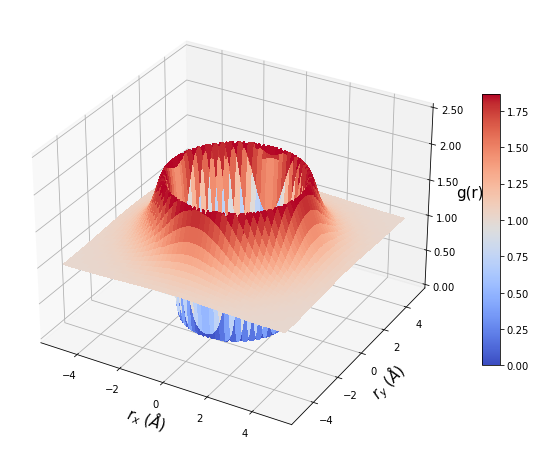

In [85]:
'''
Define the r-rdf function.
'''
def ana_rho(r, params):
    beta, epsilon, sigma = params
    return np.exp(-beta*4*epsilon*((sigma/r)**12 - (sigma/r)**6))

temp = 300
beta = 1/(const.k)/temp/const.N_A
epsilon = 1.6*1e3
sigma = 2.6

params = [beta, epsilon, sigma]

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))

# Make data.
r_x = np.linspace(-5, 5, 10000)
r_y = np.linspace(-5, 5, 10000)
r_x, r_y = np.meshgrid(r_x, r_y)
r = np.sqrt(r_x**2 + r_y**2)
g_r = ana_rho(r, params)

# Plot the surface.
surf = ax.plot_surface(r_x, r_y, g_r, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, label='T=300 K')

# Customize the z axis.
ax.set_zlim(0, 2.5)
ax.zaxis.set_major_locator(LinearLocator(6))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=15)

ax.set_xlabel(r'$r_x$ ($\AA$)', fontsize=15, rotation=0)
ax.set_ylabel(r'$r_y$ ($\AA$)', fontsize=15, rotation=0)
ax.set_zlabel('g(r)', fontsize=15, rotation=0)
# plt.title("T=300 K")
plt.show()

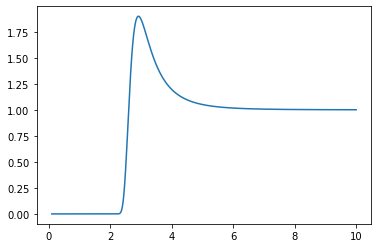

In [97]:
''' 
beta, epsilon, sigma = params
'''
def ana_rho(r, params):
    beta, epsilon, sigma = params
    return np.exp(-beta*4*epsilon*((sigma/r)**12 - (sigma/r)**6))

beta = 1/(const.k*1e-3)/300/const.N_A
epsilon = 1.6
sigma = 2.6

params = [beta, epsilon, sigma]
r = np.linspace(0.1, 10, 1000)
rho = ana_rho(r, params)

plt.plot(r, rho)

#### Discretized form of cDFT

1. First divide the grid into 40x40 cells $\Delta r_i = dr^2$

2. The loss function could then be defined as:

$$\mathcal{F} = kT\Delta r_i \rho(r_i)(\mathrm{ln}[\Lambda^3\rho(r_i)]-1)^T+\Delta r_i \rho(r_i)v_{ext}(r_i)^T \tag{1-1}$$

The **goal** is to minimize the loss function $\mathcal{F}$ with respect to the density $\rho(r_i)$.

***2-Dimensional case***

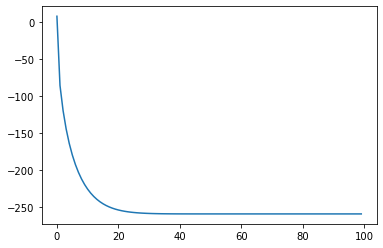

In [201]:
dr = 40 #* Number of grid points.
rho_r = torch.ones(1, dr**2, requires_grad=True, dtype=torch.float64)
with torch.no_grad():
    rho_r *= 0.03
r_i = np.linspace(-5,5,dr)
r_mesh = np.array([[i,j] for i,j in product(r_i,repeat=2)])
r_dis = np.linalg.norm(r_mesh, axis=1)

def e_(r, epsilon=1.6, sigma=2.6):
    cutoff_ind = np.where(r > 3*sigma)[0]
    min_ind = np.where(r <= 2.2)[0]

    mu = 4*epsilon*((sigma/r)**12 - (sigma/r)**6)

    mu[min_ind] = np.clip(mu[min_ind], None, 100)
    mu[cutoff_ind] = 0

    return mu

v_ext = torch.from_numpy(e_(r_dis).reshape(-1,1)) #* 400x1
v_ext = v_ext.type(torch.float64)

temp = 300
beta = 1/(const.k*1e-3)/temp/const.N_A #* Inverse of hermol energy J / mol
lamda = (beta*(const.h**2)/(2*const.pi*3.344e-26))**(1/2)
d_r2 = (10/(dr-1))**2 #* Square of cell.
''' 
First def the loss functional.
'''
def discret_f(rho_r, lamda):
    rho_r = torch.clamp(rho_r, min=1e-4)
    #* What if ignore the lambda?
    f_id_ln = torch.log(rho_r)-1
    f_id = 1/beta*d_r2*torch.mm(rho_r, f_id_ln.T)
    f_ext = d_r2*torch.mm(rho_r, v_ext)
    return f_id + f_ext

f_optimizer = torch.optim.Adam([rho_r], lr=1e-3)
relu = torch.nn.ReLU()
f_list = []
for i in range(10000):
    f_loss = discret_f(rho_r, lamda)
    f_optimizer.zero_grad()
    f_loss.backward()
    f_optimizer.step()
    if i%100 == 0:
        f_loss_ = f_loss.clone()
        f_list.append(f_loss_.detach().numpy().flatten()[0])
        clear_output(True)
        plt.plot(f_list)
        plt.show()

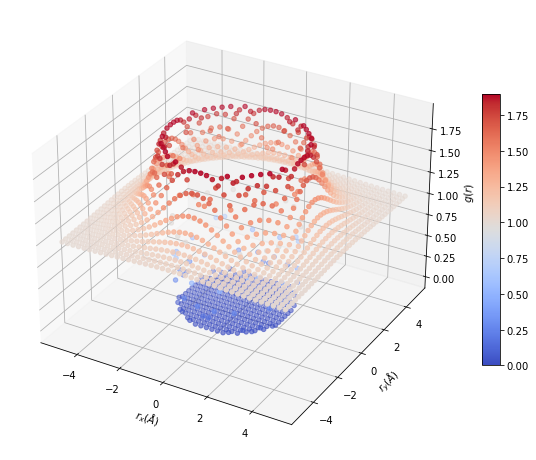

In [218]:
rho_r_ = torch.clamp(rho_r, min=0).clone()
rho_r_ = rho_r_.detach().numpy().flatten()
r_x, r_y = r_mesh[:,0], r_mesh[:,1]

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))

p = ax.scatter(r_x, r_y, rho_r_, c = rho_r_, cmap=plt.cm.coolwarm)
ax.set_xlabel(r'$r_x$ ($\AA$)', fontsize=15, rotation=0)
ax.set_ylabel(r'$r_y$ ($\AA$)', fontsize=15, rotation=0)
ax.set_zlabel('g(r)', fontsize=15, rotation=0)

fig.colorbar(p, ax=ax, shrink=0.5, aspect=15)

1-Dimensional case

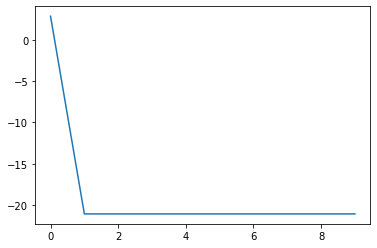

In [194]:
dr = 1000 #* Number of grid points.
rho_r = torch.ones(1, dr, requires_grad=True, dtype=torch.float64)
with torch.no_grad():
    rho_r *= 0.03
r_dis = np.linspace(0.1, 10, dr)

def e_(r, epsilon=1.6, sigma=2.6):
    cutoff_ind = np.where(r > 3*sigma)[0]
    min_ind = np.where(r <= 2.2)[0]

    mu = 4*epsilon*((sigma/r)**12 - (sigma/r)**6)

    mu[min_ind] = np.clip(mu[min_ind], None, 100)
    mu[cutoff_ind] = 0

    return mu

v_ext = torch.from_numpy(e_(r_dis).reshape(-1,1)) #* 400x1
v_ext = v_ext.type(torch.float64)

temp = 300
beta = 1/(const.k*1e-3)/temp/const.N_A #* Inverse of hermol energy J / mol
lamda = (beta*(const.h**2)/(2*const.pi*3.344e-26))**(1/2)
d_r2 = 10/(dr-1) #* Square of cell.
''' 
First def the loss functional.
'''
def discret_f(rho_r, lamda):
    rho_r = torch.clamp(rho_r, min=1e-4)
    #* What if ignore the lambda?
    f_id_ln = torch.log(rho_r)-1
    f_id = 1/beta*d_r2*torch.mm(rho_r, f_id_ln.T)
    f_ext = d_r2*torch.mm(rho_r, v_ext)
    return f_id + f_ext

f_optimizer = torch.optim.Adam([rho_r], lr=1)
relu = torch.nn.ReLU()
f_list = []
for i in range(1000):
    f_loss = discret_f(rho_r, lamda)
    f_optimizer.zero_grad()
    f_loss.backward()
    f_optimizer.step()
    if i%100 == 0:
        f_loss_ = f_loss.clone()
        f_list.append(f_loss_.detach().numpy().flatten()[0])
        clear_output(True)
        plt.plot(f_list)
        plt.show()

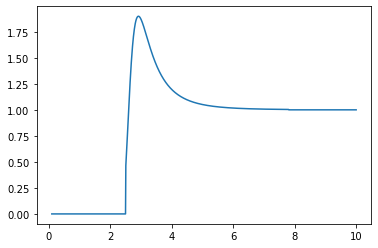

In [196]:
plt.plot(r_dis, (torch.clamp(rho_r, min=0)).detach().numpy().flatten())